In [2]:
!pip install geojson h5py pandas

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
 from geojson import GeometryCollection, Point, LineString
import h5py
import tqdm
import numpy as np


In [4]:
hf = h5py.File("/tf/pointclouds_2d/data/twitter.h5","r")
coords = hf['coords'];

bounds = [-74.7671,40.4207,-73.5256,41.0865]


len(coords)

213869519

In [5]:
bs = 2048
batches = int(len(coords)/bs)
print(f"batches: {batches}")
#batches = 1
coord_list = []
csv = "lon;lat\n"
for batch in tqdm.tqdm(range(batches)):
    #print(f"batch {batch}/{batches}")
    for c in list(coords[batch*bs:(batch+1)*bs]):
        if c[0] > bounds[0] and c[0] <bounds[2] and c[1] > bounds[1] and c[1] <bounds[3]:
            #print(c[0], c[1])            
            #coord_list.append(Point((np.asscalar(c[0]), np.asscalar(c[1]))))
            csv += str(c[0])+";"+str(c[1])+"\n"
with open('twitter_new_york.csv', 'w') as f:
    f.write(csv)

batches: 104428


  2%|▏         | 1633/104428 [00:06<06:18, 271.48it/s]


KeyboardInterrupt: 

In [ ]:
geo_collection = GeometryCollection(coord_list)
print(f"number of coords: {len(coord_list)}")

dump = geojson.dumps(geo_collection, sort_keys=True)
with open('twitter_new_york.geojson', 'w') as f:
    geojson.dump(geo_collection,  f, sort_keys=True,)

In [6]:
import pandas as pd

In [59]:
ny = pd.read_csv("twitter_new_york.csv",sep=';', names=['lon', 'lat'], usecols=['lat', 'lon'], header=0)
ny.head()

,lon,lat
0,-74.00640,40.714200
1,-74.06773,40.739060
2,-74.06773,40.739060
3,-73.84509,40.746350
4,-74.00088,40.731377


In [66]:
ny['blon']=(ny["lon"]+180)/360
ny['blat']=(ny["lat"]+90)/180
ny.head()

,lon,lat,blon,blat
0,-74.00640,40.714200,0.294427,0.726190
1,-74.06773,40.739060,0.294256,0.726328
2,-74.06773,40.739060,0.294256,0.726328
3,-73.84509,40.746350,0.294875,0.726369
4,-74.00088,40.731377,0.294442,0.726285


In [11]:
resolutions = [2048, 4096, 8192, 8192*2]

for r in resolutions:
    rh = int(r/2)
    print(r, rh)
    ny2=ny[['blat','blon']].rename({'blat':'lat','blon':'lon'}, axis=1)
    ny2['lat'] = (np.floor(ny2['lat']*r)/r *180)-90
    ny2['lon'] = (np.floor(ny2['lon']*r)/r  *360)-180
    ny2.to_csv(f'twitter_new_york_res_{r}x{r}.csv', index=False)


2048 1024


NameError: name 'ny' is not defined

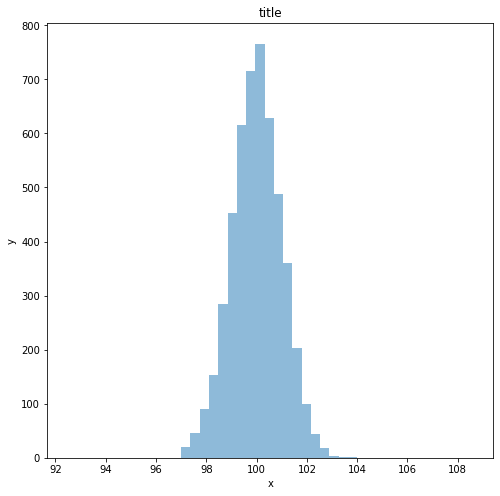

In [19]:
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib.backends.backend_pdf as pdf
from mpl_toolkits.mplot3d import axes3d
figsize = (8,8)
def save_figs(fn):
    print(f"-->  Saving all figures... {fn}")
    out_pdf = pdf.PdfPages(fn)
    for fig in tqdm.tqdm(range(1, plt.gcf().number+1)):
        out_pdf.savefig( fig )
    out_pdf.close()
    plt.close("all")
    
data = np.random.normal(100, 1, 5000) 



def plot_hist(data, title="title", xlab="x", ylab="y", bins=20, log=False):
    plt.figure(figsize=figsize)
    bins = np.linspace(math.ceil(min(data)), 
                       math.floor(max(data)),
                       bins) # fixed number of bins

    plt.xlim([min(data)-5, max(data)+5])

    if(log):
        plt.hist(np.log10(data), bins=bins, alpha=0.5)
        
    else:
        plt.hist(data, bins=bins, alpha=0.5)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)

    #plt.show()
    
plot_hist(data, bins=20)
plt.show()

In [18]:
def plot_percentiles(data, title="percentiles", size=10):
    q = np.percentile(list(rmap.values()), np.arange(0,100,size))
    plt.figure(figsize=figsize)
    names = [str(x) for x in list(np.arange(0,100,size))]
    mx = np.max(q)
    
    plt.axhline(y = 255, color = 'r', linestyle = ':', label = "8 bit")
    if(mx >= 65536):
        plt.axhline(y = 65536, color = 'r', linestyle = '--', label = "16 bit")
    if(mx >= pow(2,24)):    
        plt.axhline(y = pow(2,24), color = 'r', linestyle = '-', label = "24 bit")
    
    if(mx >= pow(2,32)):    
        plt.axhline(y = pow(2,32), color = 'r', linestyle = '-.', label = "32 bit")
    
    print(len(names),names)
    plt.bar(names,list(q))
    plt.grid()
    plt.title(title)
    plt.legend( loc = 'upper left')
    #plt.show()

plot_percentiles(data, size=5)
plt.show()

IndexError: cannot do a non-empty take from an empty axes.

In [ ]:
hf = h5py.File("/tf/pointclouds_2d/data/twitter_200mio_coords.h5","r")
datasets = [("asia_200mio","/tf/pointclouds_2d/data/asia_200mio_coords.h5"),("twitter_200mio", "/tf/pointclouds_2d/data/twitter_200mio_coords.h5")]

resolutions = [2048,4096,8192,16384]
for ds, dsfn in datasets:
    hf = h5py.File(dsfn,"r")
    coords = hf['coords'];

    len(coords)

    bs = 4096
    batches = int(len(coords)/bs)
    print(f"batches: {batches}")
    #batches = 10000
    coord_list = []
    csv = "lon;lat\n"

    for r in resolutions:
        rmap = {}
        for x in range(r):
            for y in range(r):
                id = f'{x}.{y}'
                rmap[id] = 0
        for batch in tqdm.tqdm(range(batches)):
            #print(f"batch {batch}/{batches}")
            b = coords[batch*bs:(batch+1)*bs]
            lat = b[:,1]
            lon = b[:,0]
            lat = list(np.floor((lat+90)/180*r))
            lon = list(np.floor((lon+180)/360)*r)
            for c in zip(lon, lat):
                id = f'{int(c[0])}.{int(c[1])}'
                if c in rmap:
                    rmap[c] += 1
                else:
                    rmap[c] = 1

        plot_hist(list(rmap.values()), bins=100, title=f"bins {ds} {r}", xlab="bin size", ylab="no of bins" )
        plot_percentiles(list(rmap.values()), title=f"binsize percentages {ds} {r}", size=5)

    save_figs(f'histograms_{ds}.pdf')

batches: 48828


100%|██████████| 48828/48828 [02:31<00:00, 322.51it/s]


20 ['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80', '85', '90', '95']


100%|██████████| 48828/48828 [02:31<00:00, 321.60it/s]


20 ['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80', '85', '90', '95']


100%|██████████| 48828/48828 [02:35<00:00, 314.99it/s]


20 ['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80', '85', '90', '95']


100%|██████████| 48828/48828 [02:47<00:00, 292.19it/s]
